In [3]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
import netket.jax as nkjax
# import netket_pro as nkp
import matplotlib.pyplot as plt
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from tqdm import tqdm
import jax.numpy as jnp
import jax
from matplotlib.cm import viridis, seismic, coolwarm, Spectral

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import colors
from grad_sample.utils.plotting_setup import *

In [1]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

In [2]:
%load_ext autoreload
%autoreload 2

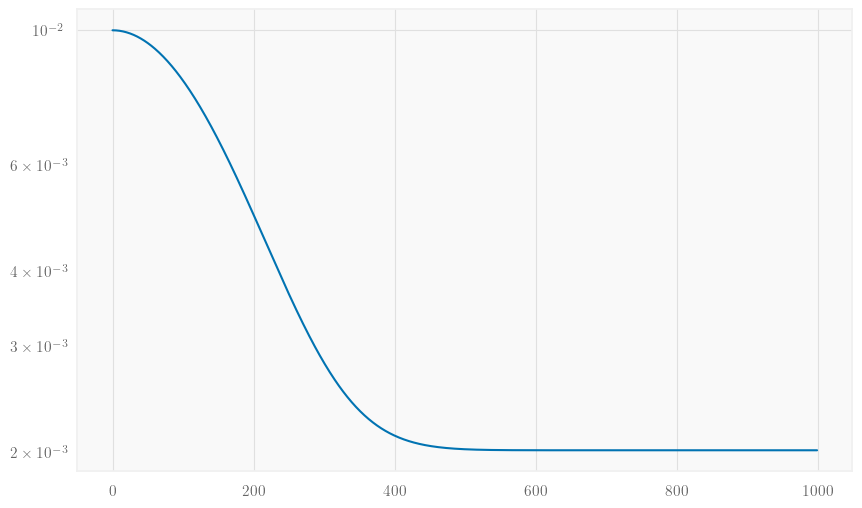

In [13]:
import optax
sch = optax.cosine_decay_schedule(
                    init_value=1e-2,
                    decay_steps=1000,
                    alpha=0.2,
                    exponent=10,
                )
plt.plot([sch(i) for i in range(1000)])
plt.yscale('log')

In [2]:
def reindex_iterations_jax(iterations):
    """
    Reindex a JAX numpy array where the iteration count resets every 1000 steps.
    
    Args:
    iterations (jnp.array): An array of iteration counts that reset periodically.

    Returns:
    jnp.array: A reindexed array with continuously increasing values.
    """
    diffs = jnp.diff(iterations, prepend=iterations[0])  # Compute differences
    resets = diffs < 0  # Detect where resets occur
    offset = jnp.cumsum(resets) * 1000  # Accumulate offset
    return iterations + offset

In [32]:
import netket as nk
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Heisenberg
from netket.exact import lanczos_ed

# Define a 4x4 square lattice with periodic boundary conditions (PBC)
L = 4  # Linear size
graph = Hypercube(length=L, n_dim=2, pbc=True)

# Define Hilbert space: Spin-1/2 system with total Sz = 0
hilbert_space = Spin(s=1/2, N=graph.n_nodes, total_sz=0, inverted_ordering=False)
# Define Heisenberg Hamiltonian
H = Heisenberg(hilbert_space, graph, J = [1.0,1.0])

# Solve using Exact Diagonalization (Lanczos)
result = lanczos_ed(H, compute_eigenvectors=False)

# Print ground-state energy
print(f"Ground state energy: {result}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


AssertionError: 

: 

Text(0.5, 0.98, 'Automatic tuning of $\\alpha$: average trajectory')

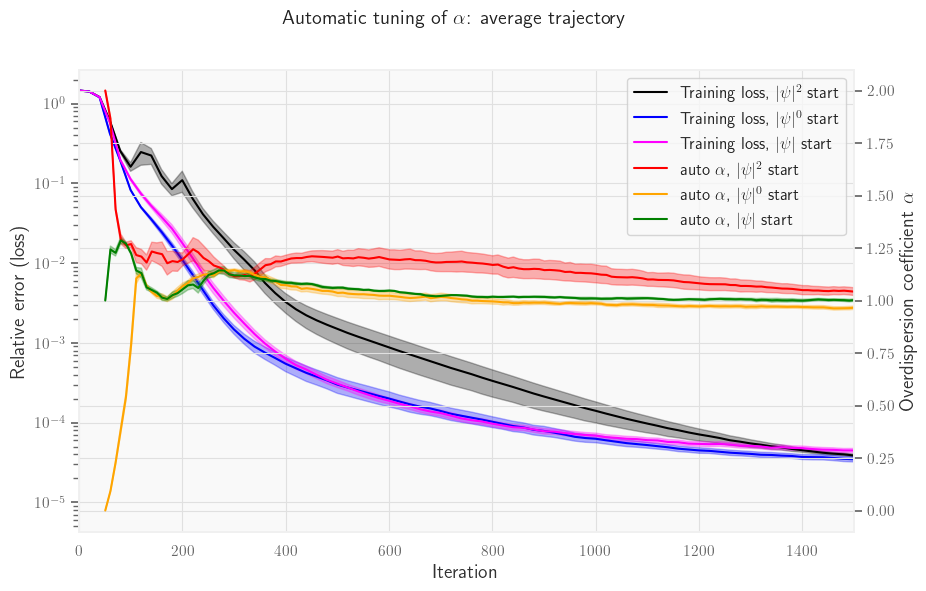

: 

In [52]:


def mean_std_rel_err(fname = 'run_', num_runs=10):
    num_conv_run = 0 
    num_runs = num_runs
    rel_err_l = []
    alphal = []
    for i in range(num_runs):
        try :
            dict_out = np.load(fname+ f'{i}.npz', allow_pickle=True)['arr_0'].item()
            rel_err = dict_out['rel_errl']
            # print(dict_out.keys())
            rel_err_it = dict_out['itrel']
            alpha_val = dict_out['al']
            alpha_it = dict_out['itvar']
            if min(rel_err) < 1e-4:
                num_conv_run +=1
                rel_err_l.append(rel_err)
                alphal.append(alpha_val)

        except :
            num_runs -= 1

    rel_err_val_l = np.stack(rel_err_l)
    mean_rel = jnp.mean(rel_err_val_l,axis=0)
    std_rel = jnp.std(rel_err_val_l,axis=0)
    ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
    ymin = mean_rel - std_rel/(2*jnp.sqrt(2))

    alpha_val_l = np.stack(alphal)
    mean_alpha = jnp.mean(alpha_val_l,axis=0)
    std_alpha = jnp.std(alpha_val_l,axis=0)
    ymax_a = mean_alpha + std_alpha/(2*jnp.sqrt(2))
    ymin_a = mean_alpha - std_alpha/(2*jnp.sqrt(2))
    return rel_err_it, mean_rel, alpha_it, mean_alpha, ymax, ymin, ymax_a, ymin_a

rel_err_it, mean_rel, alpha_it, mean_alpha, ymax, ymin, ymax_a, ymin_a = mean_std_rel_err(num_runs=5)
fig, ax = plt.subplots()
ax.plot(rel_err_it, mean_rel, color='black', label=r'Training loss, $|\psi|^2$ start')
ax.fill_between(rel_err_it, ymax, ymin, color = 'black', alpha=0.3)
ax1 = ax.twinx()
ax1.plot(alpha_it, mean_alpha, color='red', label=r'auto $\alpha$, $|\psi|^2$ start')
ax1.fill_between(alpha_it, ymax_a, ymin_a, color = 'red', alpha=0.3)

rel_err_it, mean_rel, alpha_it, mean_alpha, ymax, ymin, ymax_a, ymin_a = mean_std_rel_err(fname='run_0_start_', num_runs=5)
ax.plot(rel_err_it, mean_rel, color='blue', label=r'Training loss, $|\psi|^0$ start')
ax.fill_between(rel_err_it, ymax, ymin, color = 'blue', alpha=0.3)
# ax1 = ax.twinx()
ax1.plot(alpha_it, mean_alpha, color='orange', label=r'auto $\alpha$, $|\psi|^0$ start')
ax1.fill_between(alpha_it, ymax_a, ymin_a, color = 'orange', alpha=0.3)

rel_err_it, mean_rel, alpha_it, mean_alpha, ymax, ymin, ymax_a, ymin_a = mean_std_rel_err(fname='run_1_start_', num_runs=5)
ax.plot(rel_err_it, mean_rel, color='magenta', label=r'Training loss, $|\psi|$ start')
ax.fill_between(rel_err_it, ymax, ymin, color = 'magenta', alpha=0.3)
# ax1 = ax.twinx()
ax1.plot(alpha_it, mean_alpha, color='green', label=r'auto $\alpha$, $|\psi|$ start')
ax1.fill_between(alpha_it, ymax_a, ymin_a, color = 'green', alpha=0.3)

ax.set_ylabel('Relative error (loss)')
ax1.set_ylabel(r'Overdispersion coefficient $\alpha$')
ax.set_xlabel("Iteration")
handles, labels = ax.get_legend_handles_labels()  # from ax
handles1, labels1 = ax1.get_legend_handles_labels()  # from ax1
plt.legend(handles=handles+handles1, labels=labels+labels1)
ax.set_yscale('log')
ax.set_xlim(0,1500)
ax1.set_xlim(0,1500)
fig.suptitle(r'Automatic tuning of $\alpha$: average trajectory')

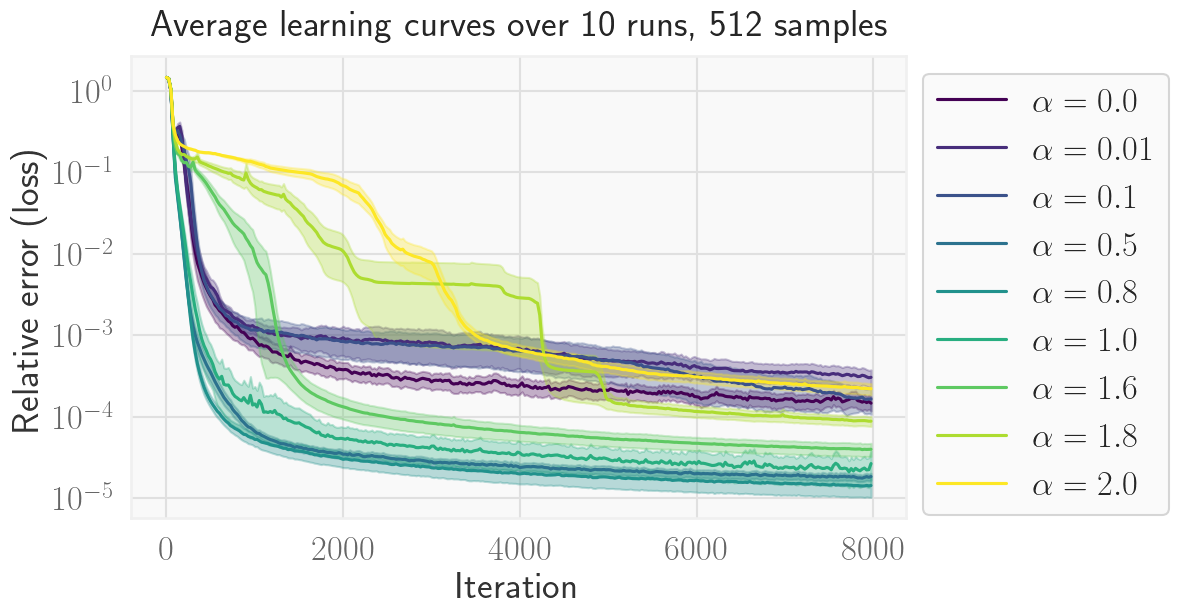

: 

In [35]:
mc_sample = 9 #2**mc_sample samples
is_keys = ['0.0', '0.01', '0.1', "0.5", "0.8", '1.0', '1.6', '1.8', '2.0']
colors = viridis(jnp.linspace(0, 1,len(is_keys)))
for idx, key in enumerate(is_keys):
    out_dict = {}
    # Define the main folder
    main_folder = f"/scratch/.amisery/grad_sample_replicas/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"
    rel_err_val_l = []
    # Iterate through subfolders
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        num_nan_runs = 0
        num_cv = 0
        num_runs = 0
        # Check if the subfolder name is in the form a_b
        # Process run log files in the subfolder
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.startswith("run_") and file.endswith(".log"):
                    file_path = os.path.join(subfolder_path, file)
                    try:
                        with open(file_path, 'r') as f:
                            log_data = json.load(f)
                            rel_err = log_data["rel_err"]["value"]
                            rel_err_it = log_data['rel_err']['iters']
                            # plt.plot(rel_err_it, rel_err, label=file_path)
                            if None in rel_err or min(rel_err) > 1e-2:
                                num_nan_runs +=1
                            elif len(rel_err) != 320:
                                print(file_path)
                            else: 
                                rel_err_val_l.append(rel_err)
                                num_cv+=1
                            num_runs +=1
                    except (json.JSONDecodeError, KeyError):
                        print(f"Warning: Could not parse file {file_path}")
    
    # Prepare data for the heatmap
    rel_err_val_l = np.stack(rel_err_val_l)
    mean_rel = jnp.mean(rel_err_val_l,axis=0)
    std_rel = jnp.std(rel_err_val_l,axis=0)
    ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
    ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
    # plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key + ' , failure ratio %.2f'%(1 - num_cv/num_runs))
    plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key)
    plt.fill_between(rel_err_it, ymax, ymin, color = colors[idx], alpha=0.3)

# num_conv_run = 0
# num_runs = 10
# rel_err_l = []
# for i in range(10):
#     try :
#         dict_out = np.load(f'run_{i}.npz', allow_pickle=True)['arr_0'].item()
#         rel_err = dict_out['rel_errl']
#         rel_err_it = dict_out['itrel']

#         if min(rel_err) < 1e-4:
#             num_conv_run +=1
#             rel_err_l.append(rel_err)
#     except :
#         num_runs -= 1

# rel_err_val_l = np.stack(rel_err_l)
# mean_rel = jnp.mean(rel_err_val_l,axis=0)
# std_rel = jnp.std(rel_err_val_l,axis=0)
# ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
# ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
# print(num_runs)
# # plt.plot(rel_err_it, mean_rel, color='black', label=r'auto $\alpha$ ($\alpha_{init} = 2$)' + ', failure ratio %.2f'%(1 - num_conv_run/num_runs))
# plt.plot(rel_err_it, mean_rel, color='black', label=r'auto $\alpha$ ($\alpha_{init} = 2$)')
# plt.fill_between(rel_err_it, ymax, ymin, color = 'black', alpha=0.3)

plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Relative error (loss)')
plt.title('Average learning curves over 10 runs, %d samples'%2**mc_sample)
plt.legend(bbox_to_anchor=(1,1))

0.5
120
120
1.0
120
120
2.0
120
120


/tmp/ipykernel_1982345/1750555524.py:43: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  rel_err = jnp.array(log_data['rel_err']['value'])


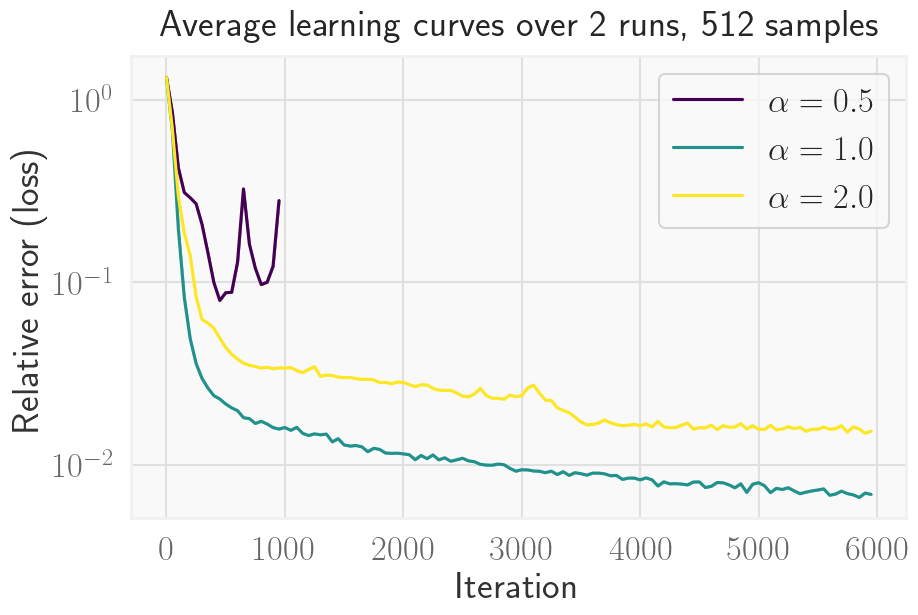

In [14]:
mc_sample = 9 #2**mc_sample samples

# Example: Get energy per site for Heisenberg 2D with J=1.0 on a 4x4 lattice for both ansatzes
model = "J1J2"
coupling = "0.5"
width = 6

# for larger models print either energy per site or rel err wrt litterature
is_keys = ['0.5', '1.0', '2.0']
colors = viridis(jnp.linspace(0, 1,len(is_keys)))

fig, ax = plt.subplots()
for idx, key in enumerate(is_keys):
    print(key)
    out_dict = {}
    # Define the main folder
    if key == '2.0':
        main_folder = base_path + f"/MC_{mc_sample}"
    else :
        main_folder = base_path + f"/MC_{mc_sample}_{key}"
    
    rel_err_val_l = []
    energies_dict = energies[model][coupling][str(width)]
    # Iterate through subfolders
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        num_nan_runs = 0
        num_cv = 0
        num_runs = 0
        # Check if the subfolder name is in the form a_b
        # Process run log files in the subfolder
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.startswith("run_") and file.endswith(".log"):
                    file_path = os.path.join(subfolder_path, file)
                    try:
                        with open(file_path, 'r') as f:
                            log_data = json.load(f)
                            rel_err = jnp.array(log_data['rel_err']['value'])
                            # if 'exact' in energies_dict.keys():
                            #     rel_err = (jnp.array(log_data["Energy"]['Mean']['real']) / width**2 / 4 - energies_dict['exact'])/jnp.abs(energies_dict['exact'])
                            # if 'qmc' in energies_dict.keys():
                            #     rel_err = (jnp.array(log_data["Energy"]['Mean']['real']) / width**2 / 4 - energies_dict['qmc'])/jnp.abs(energies_dict['qmc'])
                            # elif "pp+rvm" in energies_dict.keys():
                            #     rel_err = (jnp.array(log_data["Energy"]['Mean']['real']) / width**2 / 4 - energies_dict['pp+rbm'])/jnp.abs(energies_dict['pp+rbm'])
                            # if len(rel_err_val_l) == 0:
                            #     l_ref = len(rel_err)
                            # plt.plot(rel_err_it, rel_err, label=file_path)
                            print(len(rel_err))
                            # if jnp.nan in rel_err or min(rel_err) > 1e-2:
                            #     num_nan_runs +=1
                            #     print('nan found')
                            if len(rel_err) != 120:
                                print(file_path)
                            else: 
                                rel_err_val_l.append(rel_err)
                                # rel_err_it = reindex_iterations_jax(jnp.array(log_data['Energy']['iters']))
                                rel_err_it = jnp.array(log_data['rel_err']['iters'])
                                
                                num_cv+=1
                            num_runs +=1
                    except (json.JSONDecodeError, KeyError):
                        print(f"Warning: Could not parse file {file_path}")
    def moving_average(loss, window=10):
        """
        Computes the moving average of the loss array.
        
        Args:
            loss (jnp.ndarray): Array of loss values.
            window (int): Window size for the moving average.
            
        Returns:
            jnp.ndarray: Smoothed loss array of the same length.
        """
        kernel = jnp.ones(window) / window
        smoothed_loss = jnp.convolve(loss, kernel, mode='same')
        
        return smoothed_loss
    # Prepare data for the heatmap
    if len(rel_err_val_l) > 0:
        rel_err_val_l = np.stack(rel_err_val_l)
        mean_rel = moving_average(jnp.mean(rel_err_val_l,axis=0), window=1)
        print(len(rel_err_it))
        std_rel = jnp.std(rel_err_val_l,axis=0)
        ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
        ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
        # plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key + ' , failure ratio %.2f'%(1 - num_cv/num_runs))
        ax.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key)
        ax.fill_between(rel_err_it, ymax, ymin, color = colors[idx], alpha=0.3)

# num_conv_run = 0
# num_runs = 10
# rel_err_l = []
# for i in range(10):
#     try :
#         dict_out = np.load(f'run_{i}.npz', allow_pickle=True)['arr_0'].item()
#         rel_err = dict_out['rel_errl']
#         rel_err_it = dict_out['itrel']

#         if min(rel_err) < 1e-4:
#             num_conv_run +=1
#             rel_err_l.append(rel_err)
#     except :
#         num_runs -= 1

# rel_err_val_l = np.stack(rel_err_l)
# mean_rel = jnp.mean(rel_err_val_l,axis=0)
# std_rel = jnp.std(rel_err_val_l,axis=0)
# ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
# ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
# print(num_runs)
# # plt.plot(rel_err_it, mean_rel, color='black', label=r'auto $\alpha$ ($\alpha_{init} = 2$)' + ', failure ratio %.2f'%(1 - num_conv_run/num_runs))
# plt.plot(rel_err_it, mean_rel, color='black', label=r'auto $\alpha$ ($\alpha_{init} = 2$)')
# plt.fill_between(rel_err_it, ymax, ymin, color = 'black', alpha=0.3)

# auto_is = json.load(open('/home/amisery/phd/run_0_auto_is.log'))
# ax.plot(auto_is['rel_err']['iters'], auto_is['rel_err']['value'], color='black', label='auto alpha')

# ax1 = ax.twinx()
# ax1.plot(auto_is['alpha']['iters'], auto_is['alpha']['value'], label='auto alpha', color='black')

ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative error (loss)')
ax.set_title('Average learning curves over 2 runs, %d samples'%2**mc_sample)
ax.legend(bbox_to_anchor=(1,1))

In [ ]:
import os
import json

def extract_info_from_folder(folder_name):
    """Extract diagshift and nsamples values from folder name."""
    parts = folder_name.split("_")
    info = {}
    for part in parts:
        if "nsamples=" in part:
            info["nsamples"] = int(part.split("=")[1])
    return info

def process_log_file(file_path):
    """Extract the minimum value from the log file under ['inf_fs']['value']."""
    min_value = float("inf")
    try:
        with open(file_path, "r") as f:
            for line in f:
                try:
                    log_entry = json.loads(line)
                    value = log_entry.get("inf_fs", {}).get("value")
                    if value is not None:
                        min_value = min(min_value, value)
                except json.JSONDecodeError:
                    continue
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    
    return min_value if min_value != float("inf") else None

def main(base_folder):
    """Main function to iterate through subfolders and process log files."""
    out_dict = {}

    for subfolder in os.listdir(base_folder):
        subfolder_path = os.path.join(base_folder, subfolder)

        if os.path.isdir(subfolder_path):
            folder_info = extract_info_from_folder(subfolder)
            nsamples = folder_info.get("nsamples")

            if nsamples is not None:
                log_file_path = os.path.join(subfolder_path, "data", "optim.log")
                min_value = process_log_file(log_file_path)

                if min_value is not None:
                    if nsamples not in out_dict:
                        out_dict[nsamples] = min_value
                    else:
                        out_dict[nsamples] = min(out_dict[nsamples], min_value)

    return out_dict

# Example usage:
base_folder = "/path/to/your/folder"
result = main(base_folder)
print(result)

In [ ]:
# Example: Get energy per site for Heisenberg 2D with J=1.0 on a 4x4 lattice for both ansatzes
base_path = '/lustre/fswork/projects/rech/rgs/uur87qh/scratch_link/vit_runs_bis/J1J2_0.5/L36/ViT2D/4_24_12'
model = "J1J2"
coupling = "0.5"
width = 6

# for larger models print either energy per site or rel err wrt litterature
mc_samples = [8, 9, 10, 11, 12]
is_keys = ['0.01', '0.1', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2', '1.4', '1.6', '1.8', '2.0']
colors = viridis(jnp.linspace(0, 1,len(is_keys)))

fig, ax = plt.subplots()

for idx, key in enumerate(is_keys):
    m_list = []
    for mc_sample in mc_samples:
        
        # Define the main folder
        if key == '2.0':
            main_folder = base_path + f"/MC_{mc_sample}"
        else :
            main_folder = base_path + f"/MC_{mc_sample}_{key}"
        
        rel_err_val_l = []
        m_rel = 100
        good_run = False
        # Iterate through subfolders
        try:
            for subfolder in os.listdir(main_folder):
                subfolder_path = os.path.join(main_folder, subfolder)
                num_nan_runs = 0
                num_cv = 0
                num_runs = 0
                # Check if the subfolder name is in the form a_b
                # Process run log files in the subfolder
                good_run = True
                if os.path.isdir(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        if file.startswith("run_") and file.endswith(".log"):
                            file_path = os.path.join(subfolder_path, file)
                            try:
                                with open(file_path, 'r') as f:
                                    log_data = json.load(f)
                                    rel_err = jnp.array(log_data['rel_err']['value'])
                                    m_rel = min(min(rel_err), m_rel)
                                    # if 'exact' in energies_dict.keys():
                                    #     rel_err = (jnp.array(log_data["Energy"]['Mean']['real']) / width**2 / 4 - energies_dict['exact'])/jnp.abs(energies_dict['exact'])
                                    # if 'qmc' in energies_dict.keys():
                                    #     rel_err = (jnp.array(log_data["Energy"]['Mean']['real']) / width**2 / 4 - energies_dict['qmc'])/jnp.abs(energies_dict['qmc'])
                                    # elif "pp+rvm" in energies_dict.keys():
                                    #     rel_err = (jnp.array(log_data["Energy"]['Mean']['real']) / width**2 / 4 - energies_dict['pp+rbm'])/jnp.abs(energies_dict['pp+rbm'])
                                    # if len(rel_err_val_l) == 0:
                                    #     l_ref = len(rel_err)
                                    # plt.plot(rel_err_it, rel_err, label=file_path)
                                    print(len(rel_err))
                                    if len(rel_err) == 120 and not jnp.nan in rel_err:
                                        good_run = True
                                    # if jnp.nan in rel_err or min(rel_err) > 1e-2:
                                    #     num_nan_runs +=1
                                    #     print('nan found')
                            except (json.JSONDecodeError, KeyError):
                                print(f"Warning: Could not parse file {file_path}")
            if good_run:
                m_list.append(m_rel)
        except:
            pass    
        # Prepare data for the heatmap
       
    # plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key + ' , failure ratio %.2f'%(1 - num_cv/num_runs))
    print(m_list)
    ax.scatter(2**jnp.array(mc_samples[:len(m_list)]), m_list, color = colors[idx], label=r'$\alpha = %s$'%key)
    ax.set_xscale('log', base=2)

ax.legend()
ax.set_yscale('log')
ax.set_xlabel('sample size')
ax.set_ylabel('Best relative error')
ax.set_title('Scaling of relative error vs samples, same hparams, 6x6 J1J2, J2=0.5')
ax.legend(bbox_to_anchor=(1,1))

8
120
1
/home/amisery/scratch_link/grad_sample_vit_replicas_large_nosym_auto/J1J2_0.5/L36/ViT2D/alpha4/MC_8/0.001_schedule/run_1.log
120
9
120
120
10
120
4
/home/amisery/scratch_link/grad_sample_vit_replicas_large_nosym_auto/J1J2_0.5/L36/ViT2D/alpha4/MC_10/0.001_schedule/run_3.log
120
11
1
/home/amisery/scratch_link/grad_sample_vit_replicas_large_nosym_auto/J1J2_0.5/L36/ViT2D/alpha4/MC_11/0.001_schedule/run_0.log
120
120
12
1
/home/amisery/scratch_link/grad_sample_vit_replicas_large_nosym_auto/J1J2_0.5/L36/ViT2D/alpha4/MC_12/0.001_schedule/run_0.log
120
120


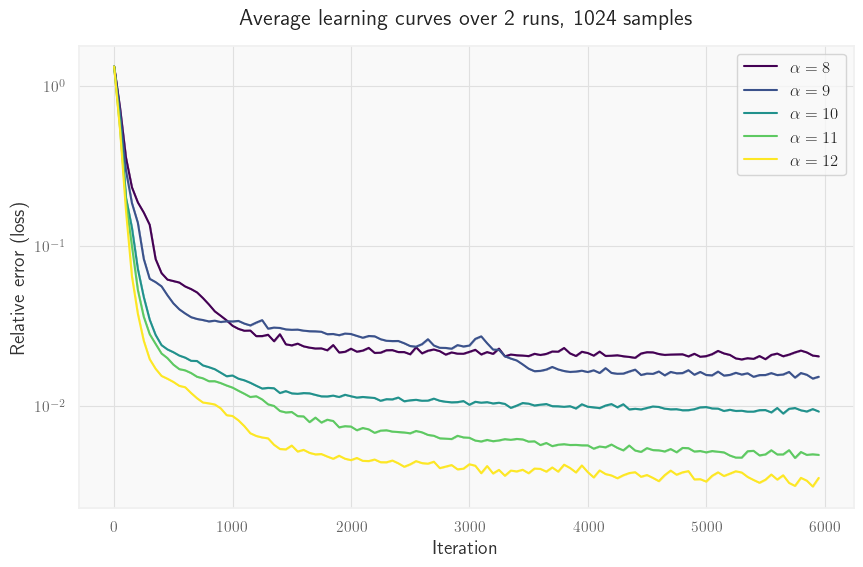

In [3]:
mc_sample = 10 #2**mc_sample samples

# Example: Get energy per site for Heisenberg 2D with J=1.0 on a 4x4 lattice for both ansatzes
model = "J1J2"
coupling = "0.5"
width = 6

# for larger models print either energy per site or rel err wrt litterature
sample_sizes = [8, 9, 10, 11, 12]
colors = viridis(jnp.linspace(0, 1,len(sample_sizes)))

fig, ax = plt.subplots()
for idx, key in enumerate(sample_sizes):
    print(key)
    out_dict = {}
    # Define the main folder
    main_folder = base_path +  f"/MC_{key}/0.001_schedule"
    rel_err_val_l = []
    # Iterate through subfolders
    
    if os.path.isdir(main_folder):
        for file in os.listdir(main_folder):
            if file.startswith("run_") and file.endswith(".log"):
                file_path = os.path.join(main_folder, file)
                try:
                    with open(file_path, 'r') as f:
                        log_data = json.load(f)
                        rel_err = jnp.array(log_data['rel_err']['value'])
                        print(len(rel_err))
                        # if jnp.nan in rel_err or min(rel_err) > 1e-2:
                        #     num_nan_runs +=1
                        #     print('nan found')
                        if len(rel_err) != 120:
                            print(file_path)
                        else: 
                            rel_err_val_l.append(rel_err)
                        # rel_err_it = reindex_iterations_jax(jnp.array(log_data['Energy']['iters']))
                            rel_err_it = jnp.array(log_data['rel_err']['iters'])
                            
                        # num_cv+=1
                        # num_runs +=1
                except (json.JSONDecodeError, KeyError):
                    print(f"Warning: Could not parse file {file_path}")
    def moving_average(loss, window=10):
        """
        Computes the moving average of the loss array.
        
        Args:
            loss (jnp.ndarray): Array of loss values.
            window (int): Window size for the moving average.
            
        Returns:
            jnp.ndarray: Smoothed loss array of the same length.
        """
        kernel = jnp.ones(window) / window
        smoothed_loss = jnp.convolve(loss, kernel, mode='same')
        
        return smoothed_loss
    # Prepare data for the heatmap
    if len(rel_err_val_l) > 0:
        rel_err_val_l = np.stack(rel_err_val_l)
        mean_rel = moving_average(jnp.mean(rel_err_val_l,axis=0), window=1)
        print(len(rel_err_it))
        std_rel = jnp.std(rel_err_val_l,axis=0)
        ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
        ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
        # plt.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key + ' , failure ratio %.2f'%(1 - num_cv/num_runs))
        ax.plot(rel_err_it, mean_rel, color = colors[idx], label=r'$\alpha = %s$'%key)
        ax.fill_between(rel_err_it, ymax, ymin, color = colors[idx], alpha=0.3)

# num_conv_run = 0
# num_runs = 10
# rel_err_l = []
# for i in range(10):
#     try :
#         dict_out = np.load(f'run_{i}.npz', allow_pickle=True)['arr_0'].item()
#         rel_err = dict_out['rel_errl']
#         rel_err_it = dict_out['itrel']

#         if min(rel_err) < 1e-4:
#             num_conv_run +=1
#             rel_err_l.append(rel_err)
#     except :
#         num_runs -= 1

# rel_err_val_l = np.stack(rel_err_l)
# mean_rel = jnp.mean(rel_err_val_l,axis=0)
# std_rel = jnp.std(rel_err_val_l,axis=0)
# ymax = mean_rel + std_rel/(2*jnp.sqrt(2))
# ymin = mean_rel - std_rel/(2*jnp.sqrt(2))
# print(num_runs)
# # plt.plot(rel_err_it, mean_rel, color='black', label=r'auto $\alpha$ ($\alpha_{init} = 2$)' + ', failure ratio %.2f'%(1 - num_conv_run/num_runs))
# plt.plot(rel_err_it, mean_rel, color='black', label=r'auto $\alpha$ ($\alpha_{init} = 2$)')
# plt.fill_between(rel_err_it, ymax, ymin, color = 'black', alpha=0.3)

# auto_is = json.load(open('/home/amisery/scratch_link/grad_sample_vit1d_runs/J1J21d_0.4/L100/ViT1D/alpha8/MC_10_isauto/0.001_schedule/run_0.log'))
# ax.plot(auto_is['rel_err']['iters'], auto_is['rel_err']['value'], color='black', label='auto alpha')

# ax1 = ax.twinx()
# ax1.plot(auto_is['alpha']['iters'], auto_is['alpha']['value'], label='auto alpha', color='black')

ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative error (loss)')
ax.set_title('Average learning curves over 2 runs, %d samples'%2**mc_sample)
ax.legend(bbox_to_anchor=(1,1))

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import colors
mc_sample = 10 #2**mc_sample samples
is_keys = ['0.0', '0.01', '0.1', '0.4', "0.5", '0.6', "0.8", '1.0', '1.2', '1.4', '1.6', '1.8', '2.0']
colors = viridis(jnp.linspace(0, 1,len(is_keys)))


def get_best_err(mc_sample):
    out_l_mean = []
    out_l_std = []
    cv_l = []
    for idx, key in enumerate(is_keys):
        out_dict = {}
        # Define the main folder
        main_folder = f"/scratch/.amisery/grad_sample_replicas/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"
        rel_err_val_l = []
        # Iterate through subfolders
        for subfolder in os.listdir(main_folder):
            subfolder_path = os.path.join(main_folder, subfolder)
            num_nan_runs = 0
            num_cv = 0
            num_runs = 0
            
            # Check if the subfolder name is in the form a_b
            # Process run log files in the subfolder
            m_alpha_l = []
            if os.path.isdir(subfolder_path):
                for file in os.listdir(subfolder_path):
                    if file.startswith("run_") and file.endswith(".log"):
                        file_path = os.path.join(subfolder_path, file)
                        try:
                            with open(file_path, 'r') as f:
                                log_data = json.load(f)
                                rel_err = log_data["rel_err"]["value"]
                                rel_err_it = log_data['rel_err']['iters']
                                # plt.plot(rel_err_it, rel_err, label=file_path)
                                if None in rel_err or min(rel_err) > 1e-2:
                                    num_nan_runs +=1
                                elif len(rel_err) != 320:
                                    print(file_path)
                                else: 
                                    m_alpha_l.append(min(rel_err))
                                    num_cv+=1
                                num_runs +=1
                        except (json.JSONDecodeError, KeyError):
                            print(f"Warning: Could not parse file {file_path}")
            out_l_mean.append(jnp.mean(jnp.array(m_alpha_l)))
            out_l_std.append(jnp.std(jnp.array(m_alpha_l)))
            cv_l.append(num_cv/num_runs)
    return jnp.array(out_l_mean), jnp.array(out_l_std), cv_l

    # Prepare data for the heatmap
mean, std, cv_l = get_best_err(9)
f_key = [float(a) for a in is_keys]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(f_key, mean)
ax1.fill_between(f_key , mean + std/2, mean - std/2, label='%d samples'%(2**9), alpha=0.3)
ax2.plot(f_key, cv_l)
out_l_mean, out_l_std, cv_l = get_best_err(10)
ax2.plot(f_key, cv_l)
ax1.plot(f_key, out_l_mean)
ax1.fill_between(f_key, out_l_mean + out_l_std/2, out_l_mean - out_l_std/2, label='%d samples'%(2**10), alpha=0.3)

num_conv_run = 0
num_runs = 10
rel_err_l = []
m_l = []
for i in range(10):
    try :
        dict_out = np.load(f'run_{i}.npz', allow_pickle=True)['arr_0'].item()
        rel_err = dict_out['rel_errl']
        rel_err_it = dict_out['itrel']
        
        if min(rel_err) < 1e-4:
            m_l.append(min(rel_err))
    except :
        num_runs -= 1
m_l = jnp.array(m_l)
auto_mean = jnp.mean(m_l)
auto_std = jnp.std(m_l)
ax1.fill_between(f_key, auto_mean + auto_std/2, auto_mean - auto_std/2, label='Automatic tuning, %d samples'%(2**9), color= 'black', alpha=0.3)
ax1.hlines(jnp.mean(m_l),0, 2, color = 'black')        
ax1.set_yscale('log')
fig.suptitle('Mean best relative error (loss)')
ax2.set_ylabel('convergence rate')
ax1.set_ylabel('Relative error (loss)')
ax1.set_xlabel(r'Overdispersion coefficient $\alpha$')
ax1.legend(bbox_to_anchor=(0.35, 0.6), fontsize=15)
# ax1.legend()

[]
[]
[]
[]
[]
[]
[]
dict_keys(['Energy'])


Text(0, 0.5, 'relative error wrt ed')

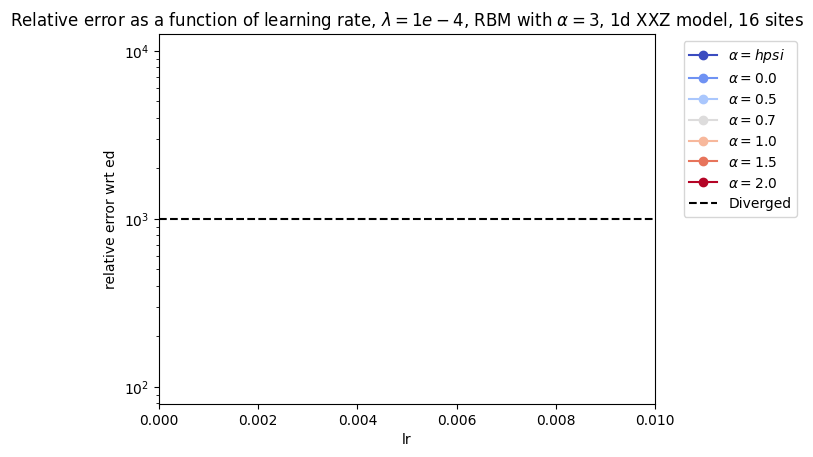

: 

In [5]:
import os
import re
import json

def find_matching_folders_and_files(base_folder):
    # Regex patterns for folder and file matching
    folder_pattern = re.compile(r'^\d+(\.\d+)_0.0001$')  # Matches 'a_0.0001' where 'a' is a float
    file_pattern = re.compile(r'^run_\d.log$')  # Matches 'run_b.log' where 'b' is a float

    results = []

    # Walk through the directory
    for root, dirs, files in os.walk(base_folder):
        for dir_name in dirs:
            if folder_pattern.match(dir_name):
                folder_path = os.path.join(root, dir_name)
                
                for file_name in os.listdir(folder_path):
                    
                    if file_pattern.match(file_name):
                        results.append((folder_path, file_name))

    return results

is_keys = ['hpsi', "0.0", "0.5", '0.7', "1.0", '1.5', "2.0"]

colors = coolwarm(jnp.linspace(0, 1,len(is_keys)))
i=0
for key in is_keys:
    out_dict = {}
    # Specify the folder to search
    mc_sample = 9
    base_folder = f"/scratch/.amisery/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}"

    # Find matching folders and files
    matches = find_matching_folders_and_files(base_folder)
    for folder, file in matches:
        match = re.search(r"/([\d.]+)_", folder)
        lr = float(match.group(1))
        if lr not in out_dict.keys():
            out_dict[lr] = 1000
        run_dir_path = os.path.join(folder, file)
        with open(run_dir_path, 'r') as f:
            log_data = json.load(f)
            rel_err = log_data["rel_err"]["value"]
            if None in rel_err:
                m = 1000
            else: 
                m = min(rel_err)
            out_dict[lr] = min(out_dict[lr], m)
    # Check if the subfolder name is in the form a_b
    sorted_items = jnp.array(sorted(out_dict.items()))

    def get_sorted_keys_and_values(input_dict):
        """
        Returns the keys and values of a dictionary sorted by the keys.

        Args:
            input_dict (dict): The input dictionary.

        Returns:
            tuple: A tuple containing two lists - sorted keys and their corresponding values.
        """
        sorted_keys = sorted(input_dict.keys())
        print(sorted_keys)
        sorted_values = [input_dict[key] for key in sorted_keys]
        return sorted_keys, sorted_values


    sorted_keys, sorted_vals = get_sorted_keys_and_values(out_dict)
    plt.plot(sorted_keys, sorted_vals, '-o', label= r'$\alpha=%s$'%key, color=colors[i])
    i+=1
    # plt.scatter(out_dict.keys(), out_dict.values(),label= r'$\alpha=%s$'%key)
    # if sorted_items.size > 0:
    #     plt.plot(sorted_items[:,0], sorted_items[:,1],label= r'$\alpha=%s$'%key)
fs_res = json.load(open('/home/amisery/scratch_link/grad_sample/xxz_1.5/L16/RBM/alpha3/saved_10_3.log'))
print(fs_res.keys())
# plt.xlim(min(out_dict.keys()),0.1)
plt.title(r'Relative error as a function of learning rate, $\lambda = 1e-4$, RBM with $\alpha = 3$, 1d XXZ model, 16 sites')
plt.hlines(1e3, 0, 0.01, color='black', linestyles='--', label='Diverged')
plt.yscale('log')
# plt.xscale('log')
plt.xlim(0, 0.01)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.xlabel('lr')
plt.ylabel('relative error wrt ed')

## Analysis : SNR of gradients and normalization over training

looking at the plot above, we find the best learning rate for each distribution and look at the SNR of the gradient and the effective sample size (related to the easiness of estimating the ratio ofnormalization constants) over training. For $lr= 0.0022$, the results looks good for most distribution.

In [8]:
import json
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_0.5/0.002_0.0001/run_2.log'))
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_2.0/0.002_0.0001/run_0.log'))
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_0.0/0.0022_0.0001/run_0.log'))
snr_log = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/xxz_1.5/L16/RBM/alpha3/MC_9_1.99/0.0022_0.0001/run_0.log'))
snr_log_ising_2 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_2.0/0.0022_1e-07/run_11.log'))
snr_log_ising_17 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.7/0.0022_1e-07/run_8.log'))
snr_log_ising_05 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_0.5/0.0022_1e-07/run_1.log'))
snr_log_ising_01 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_0.1/0.0022_1e-07/run_0.log'))

# snr_log_ising_19 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.9/0.0022_1e-07/run_0.log'))

# snr_log_ising_199 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.99/0.0022_1e-07/run_0.log'))
# snr_log_ising_19999 = json.load(open('/home/amisery/scratch_link/grad_sample_mc_hparams/ising_1.0/L4/RBM/alpha3/MC_9_1.9999/0.0022_1e-07/run_0.log'))

: 

/tmp/ipykernel_656507/3190274468.py:3: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  plt.plot(jnp.array(snr_log_ising_01['snr_jac']['value']), label='snr_jac01')


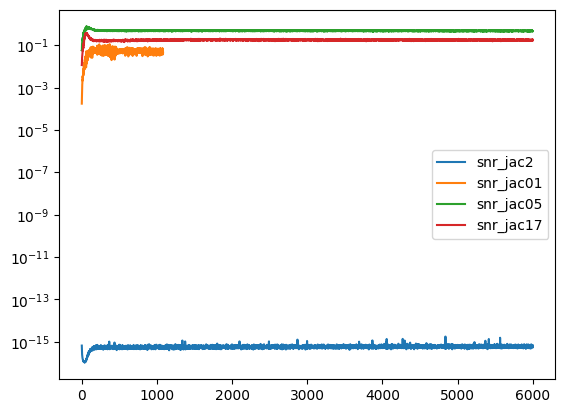

: 

In [9]:
import jax.numpy as jnp
plt.plot(jnp.array(snr_log_ising_2['snr_jac']['value']), label='snr_jac2')
plt.plot(jnp.array(snr_log_ising_01['snr_jac']['value']), label='snr_jac01')
plt.plot(jnp.array(snr_log_ising_05['snr_jac']['value']), label='snr_jac05')
plt.plot(jnp.array(snr_log_ising_17['snr_jac']['value']), label='snr_jac17')
# plt.plot(jnp.array(snr_log_ising_19['snr_jac']['value']), label='snr_jac19')
# plt.plot(jnp.array(snr_log_ising_199['snr_jac']['value']), label='snr_jac199')
# plt.plot(jnp.array(snr_log_ising_19999['snr_jac']['value']), label='snr_jac19999')
# plt.plot(jnp.array(snr_log['snr_f']['value']), label='snr_f')
plt.yscale('log')
plt.legend()

In [6]:
import math

def min_inf(*values):
    """
    Returns the minimum value among the input values.
    If any value is None or NaN, returns float('inf').
    """
    for value in values:
        if value is None or (isinstance(value, float) and math.isnan(value)):
            return float('inf')
    return min(values)

: 

: 

: 

: 

In [7]:
import json
mc_sample = 10 #2**mc_sample samples
is_keys = ["hpsi", "0.0",  "0.5", "1.0", "1.3", "2.0"]
diag_shift = "10_4"
out_dict = {}

for key in is_keys:
    out_dict[key] = {}
    out_dict[key]["rel_err"] = json.load(open(f"/scratch/.amisery/grad_sample/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}/saved_{diag_shift}.log"))["rel_err"]
    out_dict[key]["out_path"] = f"/scratch/.amisery/grad_sample/xxz_1.5/L16/RBM/alpha3/MC_{mc_sample}_{key}/saved_{diag_shift}/"

: 

: 

: 

: 